In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'iframe'
pd.set_option('display.max_columns', None)
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.nonparametric.smoothers_lowess import lowess
from pygam import ExpectileGAM
from price_optimisation_data import * 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score

In [6]:
file_path=os.path.join(os.getcwd(),'./price_data.csv')
df=pd.read_csv(file_path)

df.rename(columns=lambda x:x.lower(),inplace=True)

In [10]:
fig=px.scatter(df,x='price',y='quantity',size=df['quantity'])
fig.update_layout({'title':'Correlation between Price and Quantity'})

### Linear Model

In [10]:
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

In [14]:
# Using linear demand function
x_value = df['price']
y_value = df['quantity']
X = add_constant(x_value)
model = sm.OLS(y_value, X)
result = model.fit()
    
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               quantity   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     51.14
Date:                Mon, 21 Oct 2024   Prob (F-statistic):           1.66e-12
Time:                        19:24:23   Log-Likelihood:                -9231.1
No. Observations:                1000   AIC:                         1.847e+04
Df Residuals:                     998   BIC:                         1.848e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2889.2504    194.994     14.817      0.0

In [ ]:
x_value=df['price']
y_value=df['quantity']
X=add_constant(x_value)
model=sm.OLS(y_value,X)
result=model.fit()

In [ ]:
result.summary() # small p_value means we can reject the null hypothesis that price doesn't have an effect on quantity. 
# However, small R-squared means the model can't explain a lot of the response variability

In [ ]:
coefficient_pvalue=result.f_pvalue
intercept,slope=result.params

median_price=df['price'].median()
median_qty=df['quantity'].median()

price_elasticity=round(slope * (median_price/median_qty),2)

print(f'Linear Price Elasticity {price_elasticity} with p_value {coefficient_pvalue}')

### Non-Linear Price Elasticity Model

In [12]:
# using non-linear demand function
x_value=np.log(df['price'])
y_value=np.log(df['quantity'])
X=add_constant(x_value)

model=sm.OLS(y_value,X)

result=model.fit()

In [18]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               quantity   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     152.6
Date:                Mon, 21 Oct 2024   Prob (F-statistic):           1.01e-32
Time:                        19:24:37   Log-Likelihood:                -1562.7
No. Observations:                1000   AIC:                             3129.
Df Residuals:                     998   BIC:                             3139.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1370      0.449     27.027      0.000      11.256      13.018
price         -1.0683      0.086    -12.353      0.000      -1.238      -0.899
==============================================================================
Omnibus:                        9.853   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.804
Skew:                           0.221   Prob(JB):                      0.00743
Kurtosis:                       2.799   Cond. No.                         66.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
coefficient_pvalue=result.f_pvalue
intercept,slope=result.params

price_elasticity=round(slope,2)

print(f'Linear Price Elasticity {price_elasticity} with p_value {coefficient_pvalue}')

Linear Price Elasticity -1.07 with p_value 1.008356315590762e-32


In [16]:
import math

round(math.exp(12.1370),0)
print(f'The final equation is 186652 * price**{price_elasticity}')

The final equation is 186652 * price**-1.07


In [24]:
# Set price elasticity range
elasticity = -1.07

# Set price range
price = list(np.linspace(15, 1000, num=100))
demand = 186652 * np.power(price,elasticity)
revenue = price  * demand
max_revenue = np.max(revenue)
max_index = np.argmax(revenue)
price[max_index]

15.0

In [26]:
price_df=pd.DataFrame(price).rename(columns={0:'price'})

price_df['revenue']=revenue

In [28]:
fig=px.line(price_df,x='price',y='revenue')
fig.update_layout({'title':'Price vs Revennue'})

In [30]:
def create_multiple_price_elasticity_df(pe1,pe2,pe3):
    price = list(np.linspace(15, 100, num=100))
    demand1 = 186552 * np.power(price,pe1)
    revenue1 = price  * demand1
    
    demand2 = 186552 * np.power(price,pe2)
    revenue2 = price  * demand2

    demand3 = 186552 * np.power(price,pe3)
    revenue3 = price  * demand3

    data={'price':price,f'{pe1}_revenue':revenue1,f'{pe2}_revenue':revenue2,f'{pe3}_revenue':revenue3}
    price_df=pd.DataFrame(data)
    
    return price_df.set_index('price')

In [32]:
price_df=create_multiple_price_elasticity_df(-0.5,-0.8,-3)

In [34]:
fig=px.line(price_df)
fig.update_layout({'title':'Three Levels of PE Price & Revenue Comparison'})


# Comparing Non linear Demand function with ExpectileGAM using Kaggle dataset

In [19]:
df=pd.read_csv('retail_price.csv')

In [100]:
agg_df=df.groupby(['product_category_name','month_year','unit_price','holiday','year'],\
                  as_index=False)[['qty','total_price']].sum()

agg_df['if_holiday']=np.where(agg_df.holiday!=0,'1','0')
agg_df['year']=agg_df['year'].astype('str')

In [98]:
fig=px.scatter(agg_df,x='unit_price',y='qty',color='if_holiday',facet_col='product_category_name',facet_col_wrap=2,
           facet_row_spacing=0.1,facet_col_spacing=0.1,opacity=0.6,trendline='lowess',trendline_color_override='blue',
           template='none',title='Product Sales Holiday Analysis',width=600,height=700
).update_traces(
    marker=dict(size=7),hoverlabel=dict(font=dict(size=10))
)

fig.show('iframe')
## Observation: some products are inelastic, such as Bed_Bath, some are very price sensitvie such as garden tools.\
## Sales mostly made in holiday seasons
# Furniture deco is inelastic until price surpass certain 69

Text(0.5, 1.0, 'KDE Plot for Unit Price per Product')

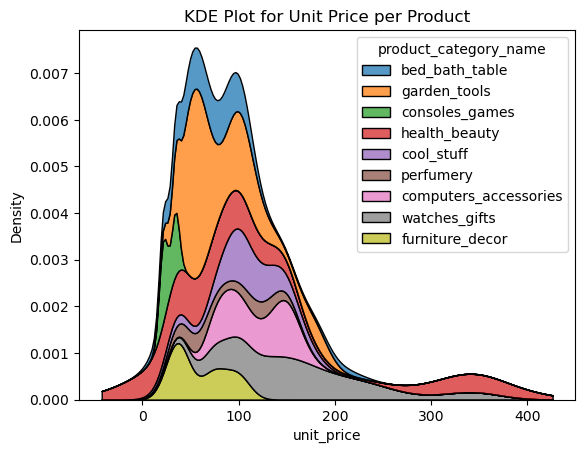

In [21]:
sns.kdeplot(df,x='unit_price',hue='product_category_name',multiple="stack").set_title('KDE Plot for Unit Price per Product')

In [108]:
agg_df.product_category_name.value_counts()

product_category_name
health_beauty            130
watches_gifts            102
garden_tools              93
computers_accessories     69
bed_bath_table            61
cool_stuff                46
furniture_decor           38
perfumery                 26
consoles_games            16
Name: count, dtype: int64

In [118]:
px.scatter(agg_df.loc[agg_df['product_category_name']=='garden_tools'], x='unit_price', y='qty', \
           trendline='lowess', width=800, height=600, title='Price vs Quantity Sold for garden Tools')

In [122]:
# defining a function to create and find price elasticity using non-linear demand function
def create_model_and_find_elasticity(df):

    # creating an OLS model and fitting it on the data
    x_value=np.log(df['unit_price'])
    y_value=np.log(df['qty'])
    X=add_constant(x_value)
    model = sm.OLS(y_value,X).fit()
    # getting the price elasticity
    price_elasticity = model.params[1]
    # printing the stats
    print(f"\n\nThe price elasticity of the model is {str(price_elasticity)}\n\n")
    print(model.summary())
    # plotting
    fig = plt.figure(figsize=(10,5))
    fig = sm.graphics.plot_partregress_grid(model,fig=fig)
    plt.show()

    return price_elasticity,model

In [194]:
math.exp(9.0074)

8163.269159351996



The price elasticity of the model is -1.4625418704743813


                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     32.41
Date:                Tue, 22 Oct 2024   Prob (F-statistic):           1.51e-07
Time:                        16:17:34   Log-Likelihood:                -137.04
No. Observations:                  93   AIC:                             278.1
Df Residuals:                      91   BIC:                             283.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/var/folders/6w/xl0fj63d2814l77lzh6r8_6w0000gn/T/ipykernel_1353/1126812756.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



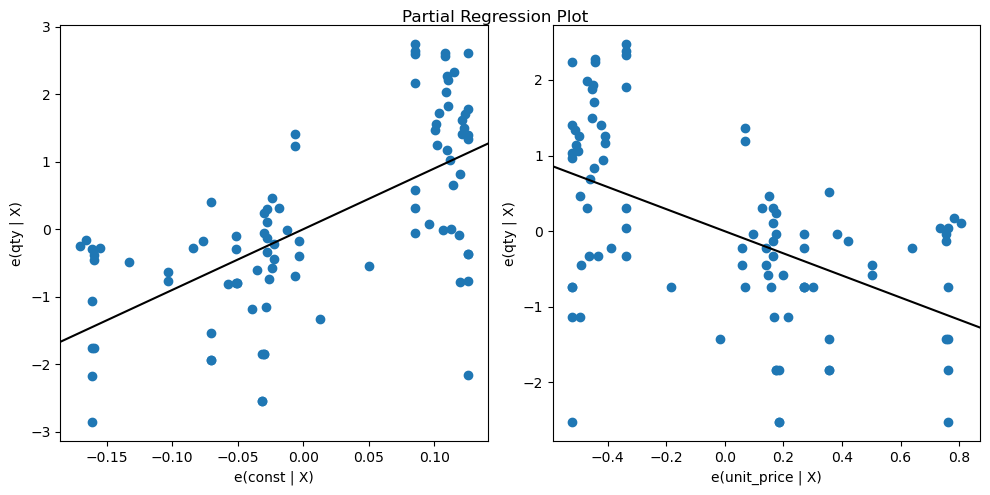

(-1.4625418704743813,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x301b1ea50>)

In [124]:
create_model_and_find_elasticity(agg_df.loc[agg_df['product_category_name']=='garden_tools'])
##The equation for garden tools qty calculation is 8163 * price ** (-1.4625)
## The R-squared is only 0.263 which means it doesn't explain the variablity of the data well 
#and as the graph shows the model doesn't capture the 'outliers' deviates from the main trend so the OLS model is not a good fit for our user case

In [ ]:
# df_encoded=agg_df.copy()

# df_encoded=pd.get_dummies(df_encoded,columns=['product_category_name'],drop_first=False) ## drop_first= False to intentionally to keep all the records

# colnames_product=df_encoded.columns[df_encoded.columns.str.startswith('product')].tolist()

# df_encoded[colnames_product]=df_encoded[colnames_product].astype(int)

# X=df_encoded[['unit_price']+colnames_product]
# X=sm.add_constant(X)
# y=df_encoded['qty']
# model=sm.OLS(y,X).fit()
# model.summary()
# pd.DataFrame(model.params).T

In [ ]:
all_gam_results=[]

for p in unique_products:
    product_data=agg_df.loc[agg_df['product_category_name']==p]
    X=product_data['unit_price']
    y=product_data['qty']
    quantiles=[0.025,0.5,0.975]
    gam_result={}
    for q in quantiles:
        gam=ExpectileGAM(expectile=q)
        gam.fit(X,y)
        gam_result[f'pred_{q}']=gam.predict(X)
    pred_gam=pd.DataFrame(gam_result).set_index(X.index)
    pred_gam_df=pd.concat([agg_df[['product_category_name','unit_price','qty','total_price']],pred_gam],axis=1)
    all_gam_results.append(pred_gam_df)

all_gam_results=pd.concat(all_gam_results)   

In [420]:
product_lists=all_gam_results['product_category_name'].unique().tolist()

In [422]:
for p in product_lists:
    plot_gam_one_product_using_lowess(all_gam_results,p)

In [368]:
all_gam_results.head()

,product_category_name,unit_price,qty,total_price,pred_0.025,pred_0.5,pred_0.975,revenue_pred_0.025,revenue_pred_0.5,revenue_pred_0.975
0,bed_bath_table,39.99,19,759.81,4.704761,12.466285,23.205160,89.390465,236.859415,440.898040
1,bed_bath_table,45.90,19,872.10,3.166853,9.604346,25.820797,60.170213,182.482572,490.595140
2,bed_bath_table,86.90,17,1477.30,4.953246,20.339733,47.476861,84.205190,345.775467,807.106639
3,bed_bath_table,98.30,11,1082.00,7.819541,19.692067,51.681987,86.014953,216.612733,568.501858
4,bed_bath_table,89.90,2,179.80,5.632293,21.130235,48.979307,11.264586,42.260469,97.958614


In [366]:
for col in all_gam_results.columns.tolist():
    if col.startswith('pred'):
        all_gam_results['revenue_'+col]=all_gam_results[col]*all_gam_results['qty']

In [402]:
# all_gam_results.groupby(['product_category_name'],as_index=False).apply(lambda x: x[x['revenue_pred_0.025']==x['revenue_pred_0.025']\
#                 .max()])

In [428]:
for p in product_lists:
    plot_revenue_gam_one_product_using_lowess(all_gam_results,p)

### Train test split Gam model 

In [433]:
agg_df.head()

,product_category_name,month_year,unit_price,holiday,year,qty,total_price,if_holiday
0,bed_bath_table,01-01-2018,39.99,2,2018,19,759.81,1
1,bed_bath_table,01-01-2018,45.90,2,2018,19,872.10,1
2,bed_bath_table,01-01-2018,86.90,2,2018,17,1477.30,1
3,bed_bath_table,01-01-2018,98.30,2,2018,11,1082.00,1
4,bed_bath_table,01-02-2017,89.90,2,2017,2,179.80,1


In [469]:
product_encoder = LabelEncoder()
holiday_encoder = LabelEncoder()

# Fit the label encoders to the categories
agg_df['encoded_product_category_name'] = product_encoder.fit_transform(agg_df['product_category_name'])
agg_df['encoded_holiday'] = holiday_encoder.fit_transform(agg_df['if_holiday'])

data=agg_df.loc[agg_df['product_category_name']=='garden_tools']
X = data[['unit_price', 'encoded_holiday']].copy()
y = data[['qty']].copy()

In [477]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

gams = []
model_train_performance = []
model_test_performance = []
df_gam_results = pd.DataFrame()
quantiles = [0.025, 0.5, 0.975]
for q in quantiles:
    # fit the model on the training data
    gam = ExpectileGAM(expectile=q).fit(X_train, y_train)   
    gams.append({"q": q, "gam_model": gam})
    # predict on the test data
    y_train_pred = gam.predict(X_train)
    y_test_pred = gam.predict(X_test)
    y_pred = gam.predict(X)
    # calculate the performance of the model on the test data
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    # calculate R-squared
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred) 
    model_train_performance.append({"q": q, "mse": train_mse, "r2": train_r2})
    model_test_performance.append({"q": q, "mse": test_mse, "r2": test_r2})
    df_gam_results[f"pred_quant_{q}"] = y_pred

In [473]:
model_train_performance

[{'q': 0.025, 'mse': 1535.4132267626019, 'r2': -0.21873506803946774},
 {'q': 0.5, 'mse': 826.837065956423, 'r2': 0.34369763769674755},
 {'q': 0.975, 'mse': 2932.245017588763, 'r2': -1.3274710473573172}]

In [475]:
model_test_performance

[{'q': 0.025, 'mse': 736.8650385639352, 'r2': -0.16165893236202722},
 {'q': 0.5, 'mse': 415.502193034143, 'r2': 0.34496575533723906},
 {'q': 0.975, 'mse': 1943.0074577654202, 'r2': -2.063128050366028}]